# SimEx VSL

Simulator...
x list [2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900]
Running sumo simulator
 Retrying in 1 seconds
Step #5400.00 (4ms ~= 62.50*RT, ~61500.00UPS, TraCI: 0ms, vehicles TOT 5999 ACT 246 BUF 0)tep #1125.00 (4ms ~= 62.50*RT, ~64250.00UPS, TraCI: 0ms, vehicles TOT 1081 ACT 257 BUF 0)ep #2250.00 (4ms ~= 62.50*RT, ~72500.00UPS, TraCI: 1ms, vehicles TOT 2425 ACT 290 BUF 0)p #3375.00 (6ms ~= 41.67*RT, ~49166.67UPS, TraCI: 1ms, vehicles TOT 3833 ACT 295 BUF 0) #4500.00 (4ms ~= 62.50*RT, ~62500.00UP

Step #5400.00 (6ms ~= 41.67*RT, ~72333.33UPS, TraCI: 0ms, vehicles TOT 7259 ACT 434 BUF 0)
x list [3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800]
Running sumo simulator
 Retrying in 1 seconds
Step #3350.00 (6ms ~= 41.67*RT, ~106833.33UPS, TraCI: 0ms, vehicles TOT 4639 ACT 641 BUF 0tep #1125.00 (5ms ~= 50.00*RT, ~67800.00UPS, TraCI: 0ms, vehicles TOT 1363 ACT 339 BUF 0)ep #2250.00 (6ms ~= 41.67*RT, ~78666.67UPS, TraCI: 0ms, vehicles TOT 2988 ACT 472 BUF 0)

Step #5400.00 (5ms ~= 50.00*RT, ~86600.00UPS, TraCI: 0ms, vehicles TOT 7349 ACT 433 BUF 0)
MAIN modx [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Validator...
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[1, 6.25]]


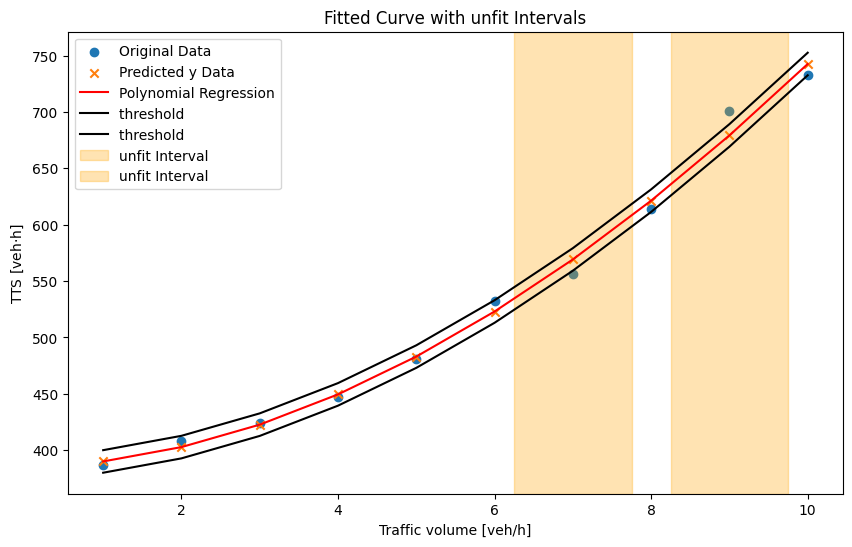

MAIN interval list from VAL: [[6.25, 7.75], [8.25, 9.75]]


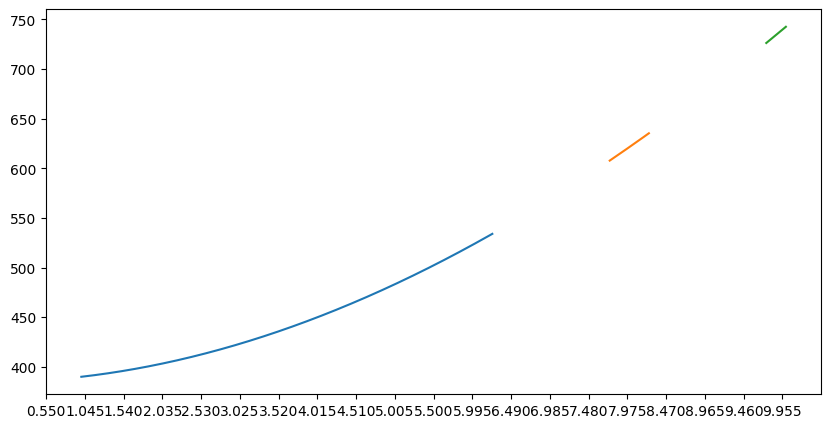

In [1]:
# IMPORT LIBRARIES
import numpy as np

from components_configuration import components
from global_settings import simexSettings,mds

from validator_controller import ValidatorController
from modifier_controller import ModifierController
from simulator_controller import SimulatorController
from logger_utils import Logger

import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        
import datetime

validator_controller_vsl = ValidatorController()
logger = Logger()
logger_main_arguments = {}
is_main_func = True

# SUMO vsl
from controller_modifier_scenarios import Controller

# SUMO vsl generate modifiers [[1,[2900,...2900],[2,[3000,...3000]....]
modlist = Controller.get_list_of_modifiers(10)
# print(f"Mod list: {modlist}")
# mod_x_list = modlist

# Calls Simulator
# Input: list of ids and modifiers [[1,[2900,...2900],[2,[3000,...3000]....]
# Output: IDs,SIMULATED(values) [[1,388.88],[2,420.22]]
# USE the sumo_simulator_vsl or sumo_simulator_novsl function such as components['sumo_simulator_novsl']
mod_x,sim_y_list = SimulatorController.simulator(modlist,selected_simulator=components['sumo_simulator_vsl_old'])
assert len(mod_x) == len(sim_y_list)

print("MAIN modx", mod_x)

# Calls Validator controller
intervals_list_vsl =  validator_controller_vsl.validate(mod_x_list=np.array(mod_x),sim_y_list=np.array(sim_y_list), selected_validator=components['validator'],global_interval=[1, 10])
print("MAIN interval list from VAL:", intervals_list_vsl)

filename1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_object(validator_controller_vsl,f"vc_vsl-{filename1}.pkl")


# MAIN cycle completed/interrupted -> write OVERALL statistics        
logger_main_arguments['log_contex'] = 'Overall Stats'                          
logger_main_arguments['main_status'] = 'end cycle'
logger.log_main(logger_main_arguments)

Modifier...
[MODC]: intervals list:  [[2500, 4500]]
[MODC]: (interval_min_tick, interval_max_tick):  (2500, 4500)
[MODC]: mod_ticks:  [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400]
[MODC]: mod_x:  [2600.0, 2675.714285714286, 2754.285714285714, 2835.714285714286, 2920.0, 3007.1428571428573, 3097.1428571428573, 3190.0, 3285.714285714286, 3384.285714285714, 3485.714285714286, 3590.0, 3697.142857142857, 3807.142857142857, 3920.0, 4035.714285714286, 4154.285714285714, 4275.714285714286, 4400.0]
MAIN mod outcome ([[2600.0, 2675.714285714286, 2754.285714285714, 2835.714285714286, 2920.0, 3007.1428571428573, 3097.1428571428573, 3190.0, 3285.714285714286, 3384.285714285714, 3485.714285714286, 3590.0, 3697.142857142857, 3807.142857142857, 3920.0, 4035.714285714286, 4154.285714285714, 4275.714285714286, 4400.0]], [[2500, 4500]])
Simulator...
[[2600.0, 2675.714285714286, 2754.285714285714, 2835.714285714286, 2920.0, 3007.142857142

Step #5400.00 (7ms ~= 35.71*RT, ~61714.29UPS, TraCI: 0ms, vehicles TOT 7259 ACT 432 BUF 0)
x list [3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142857142857, 3807.142

Step #5400.00 (6ms ~= 41.67*RT, ~73500.00UPS, TraCI: 0ms, vehicles TOT 7349 ACT 441 BUF 0)
x list [3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0, 3920.0]
Running sumo simulator
 Retrying in 1 seconds
Step #3350.00 (6ms ~= 41.67*RT, ~113666.67UPS, TraCI: 0ms, vehicles TOT 4751 ACT 682 BUF 0tep #1125.00 (5ms ~= 50.00*RT, ~72200.00UPS, 

Step #4925.00 (6ms ~= 41.67*RT, ~89833.33UPS, TraCI: 1ms, vehicles TOT 6917 ACT 539 BUF 0)

Step #5400.00 (6ms ~= 41.67*RT, ~77000.00UPS, TraCI: 1ms, vehicles TOT 7529 ACT 462 BUF 0)
x list [4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714285714286, 4035.714

Step #5400.00 (5ms ~= 50.00*RT, ~93200.00UPS, TraCI: 1ms, vehicles TOT 7709 ACT 466 BUF 0)
x list [4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285714285714, 4154.285

Step #5400.00 (5ms ~= 50.00*RT, ~92000.00UPS, TraCI: 1ms, vehicles TOT 7889 ACT 460 BUF 0)
x list [4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714285714286, 4275.714

Step #5400.00 (6ms ~= 41.67*RT, ~75500.00UPS, TraCI: 0ms, vehicles TOT 8069 ACT 453 BUF 0)
x list [4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0, 4400.0]
Running sumo simulator
 Retrying in 1 seconds


Step #5400.00 (11ms ~= 22.73*RT, ~43727.27UPS, TraCI: 0ms, vehicles TOT 8249 ACT 481 BUF 0
MODX [2600.0, 2675.714285714286, 2754.285714285714, 2835.714285714286, 2920.0, 3007.1428571428573, 3097.1428571428573, 3190.0, 3285.714285714286, 3384.285714285714, 3485.714285714286, 3590.0, 3697.142857142857, 3807.142857142857, 3920.0, 4035.714285714286, 4154.285714285714, 4275.714285714286, 4400.0] and sim_y_list [346.1388888888888, 362.94444444444446, 367.0416666666668, 379.31944444444434, 397.61111111111114, 405.2083333333334, 426.3472222222224, 441.37499999999994, 483.44444444444446, 508.3750000000001, 550.7083333333331, 632.6111111111111, 718.6944444444443, 725.0277777777777, 756.2083333333334, 806.7222222222224, 821.0277777777777, 835.2916666666664, 874.0138888888888]
MAIN modx [2600.0, 2675.714285714286, 2754.285714285714, 2835.714285714286, 2920.0, 3007.1428571428573, 3097.1428571428573, 3190.0, 3285.714285714286, 3384.285714285714, 3485.714285714286, 3590.0, 3697.142857142857, 3807.142

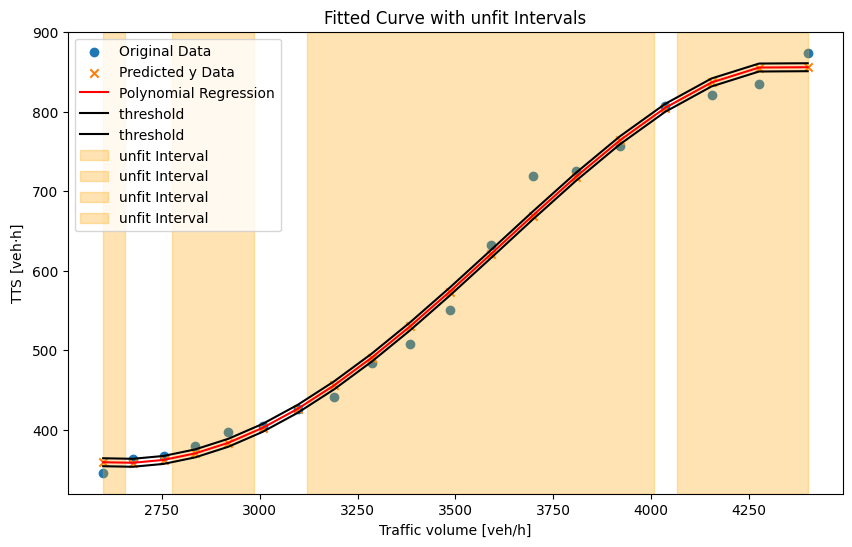

MAIN interval list from VAL: [[2600.0, 2656.785714285714], [2774.642857142857, 2985.357142857143], [3120.357142857143, 4006.785714285714], [4065.3571428571427, 4400.0]]
Modifier...
[MODC]: intervals list:  [[2600.0, 2656.785714285714], [2774.642857142857, 2985.357142857143], [3120.357142857143, 4006.785714285714], [4065.3571428571427, 4400.0]]
[MODC]: (interval_min_tick, interval_max_tick):  (2600.0, 2656.785714285714)
[MODC]: mod_ticks:  [2650]
[MODC]: mod_x:  [2650]
[MODC]: (interval_min_tick, interval_max_tick):  (2774.642857142857, 2985.357142857143)
[MODC]: mod_ticks:  [2800, 2875, 2950]
[MODC]: mod_x:  [2800.0, 2874.021739130435, 2950.0]
[MODC]: (interval_min_tick, interval_max_tick):  (3120.357142857143, 4006.785714285714)
[MODC]: mod_ticks:  [3175, 3250, 3325, 3400, 3475, 3550, 3625, 3700, 3775, 3850, 3925, 4000]
[MODC]: mod_x:  [3175.0, 3242.1602787456445, 3310.8885017421603, 3381.184668989547, 3453.048780487805, 3526.480836236934, 3601.480836236934, 3678.048780487805, 3756.18

Step #5400.00 (5ms ~= 50.00*RT, ~79000.00UPS, TraCI: 0ms, vehicles TOT 7169 ACT 395 BUF 0)
x list [3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184668989547, 3756.184

Step #5400.00 (5ms ~= 50.00*RT, ~89800.00UPS, TraCI: 0ms, vehicles TOT 7349 ACT 449 BUF 0)
x list [3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3835.8885017421603, 3

Step #5400.00 (8ms ~= 31.25*RT, ~58000.00UPS, TraCI: 1ms, vehicles TOT 7439 ACT 464 BUF 0)
x list [3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3917.1602787456445, 3

Step #5400.00 (7ms ~= 35.71*RT, ~68714.29UPS, TraCI: 0ms, vehicles TOT 7529 ACT 481 BUF 0)
x list [4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0, 4000.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~75800.00UPS, TraCI: 1ms, vehicles TOT 1437 ACT 379 BUF 0)ep #2250.00 (6ms ~= 41.67*RT, ~92666.67UPS, Tra

Step #5400.00 (5ms ~= 50.00*RT, ~94800.00UPS, TraCI: 1ms, vehicles TOT 7707 ACT 474 BUF 0)
x list [4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0, 4075.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~77800.00UPS, TraCI: 1ms, vehicles TOT 1456 ACT 389 BUF 0)ep #2250.00 (7ms ~= 35.71*RT, ~82714.29UPS, Tra

Step #4450.00 (7ms ~= 35.71*RT, ~96714.29UPS, TraCI: 0ms, vehicles TOT 6541 ACT 677 BUF 0)

Step #5400.00 (8ms ~= 31.25*RT, ~56875.00UPS, TraCI: 1ms, vehicles TOT 7799 ACT 455 BUF 0)
x list [4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002958579882, 4148.002

Step #5400.00 (5ms ~= 50.00*RT, ~93000.00UPS, TraCI: 0ms, vehicles TOT 7889 ACT 465 BUF 0)
x list [4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337278106509, 4222.337

Step #5400.00 (6ms ~= 41.67*RT, ~78833.33UPS, TraCI: 1ms, vehicles TOT 7979 ACT 473 BUF 0)
x list [4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002958579882, 4298.002

Step #5400.00 (6ms ~= 41.67*RT, ~79666.67UPS, TraCI: 1ms, vehicles TOT 8159 ACT 478 BUF 0)
x list [4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0, 4375.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~88800.00UPS, TraCI: 1ms, vehicles TOT 1550 ACT 444 BUF 0)

Step #5400.00 (6ms ~= 41.67*RT, ~75166.67UPS, TraCI: 0ms, vehicles TOT 8249 ACT 451 BUF 0)
MODX [2650, 2800.0, 2874.021739130435, 2950.0, 3175.0, 3242.1602787456445, 3310.8885017421603, 3381.184668989547, 3453.048780487805, 3526.480836236934, 3601.480836236934, 3678.048780487805, 3756.184668989547, 3835.8885017421603, 3917.1602787456445, 4000.0, 4075.0, 4148.002958579882, 4222.337278106509, 4298.002958579882, 4375.0] and sim_y_list [356.02777777777777, 378.2777777777777, 390.90277777777777, 396.6944444444443, 437.3611111111109, 466.222222222222, 480.2916666666666, 488.86111111111114, 556.8055555555555, 595.486111111111, 639.0, 685.3333333333334, 723.3611111111113, 753.4027777777779, 774.7777777777777, 812.4166666666666, 820.2638888888889, 836.6250000000001, 848.9027777777777, 863.1666666666669, 871.1250000000006]
MAIN modx [2650, 2800.0, 2874.021739130435, 2950.0, 3175.0, 3242.1602787456445, 3310.8885017421603, 3381.184668989547, 3453.048780487805, 3526.480836236934, 3601.480836236934,

/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


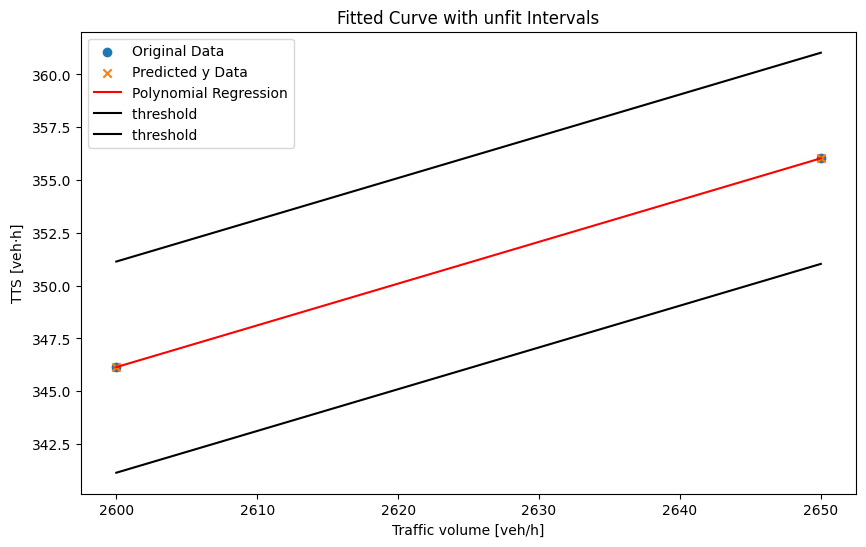

equation,
 y =  2.9178526499563515e-05x^2 + 0.044590513655071884x^1 + 32.956714248652645 
unfit_points
 [(2600.0, 346.1388888888888), (2650.0, 356.02777777777777)] 
local_unfit_interval
, [[2600.0, 2656.785714285714]]
       *** USING local_exploration_validator_A


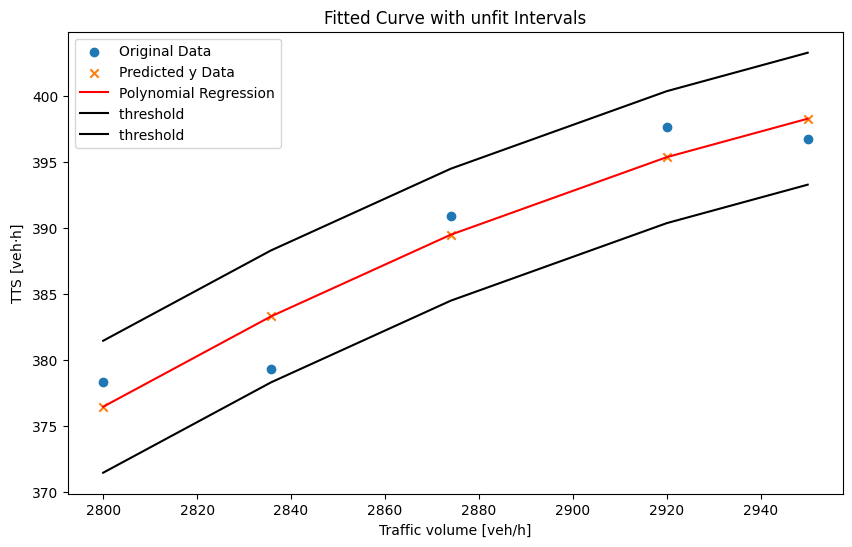

equation,
 y =  -0.0004033497721362014x^2 + 2.4647850030457343x^1  -3362.7001789918586 
unfit_points
 [(2800.0, 378.2777777777777), (2835.714285714286, 379.31944444444434), (2874.021739130435, 390.90277777777777), (2920.0, 397.61111111111114), (2950.0, 396.6944444444443)] 
local_unfit_interval
, [[2774.642857142857, 2985.357142857143]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3120.357142857143, 3175.0]]


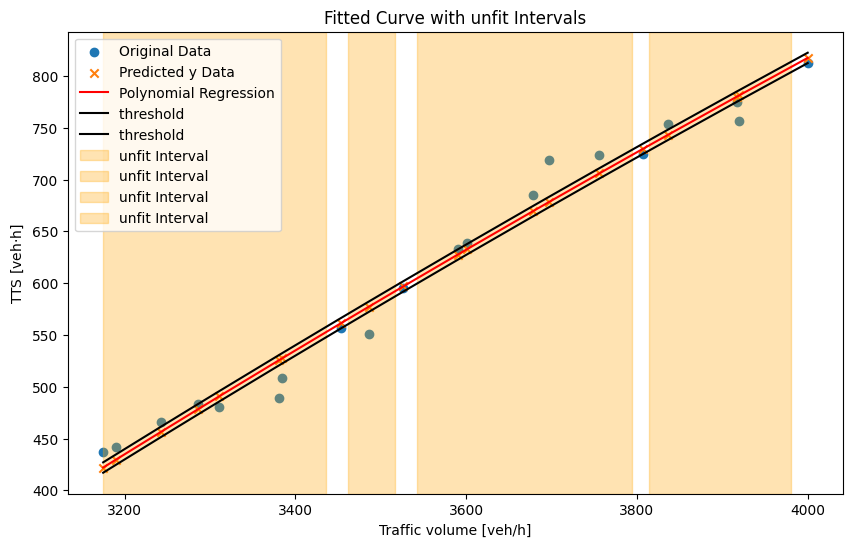

equation,
 y =  -3.845006838625384e-05x^2 + 0.755084195460238x^1  -1587.7796275498224 
unfit_points
 [(3175.0, 437.3611111111109), (3190.0, 441.37499999999994), (3242.1602787456445, 466.222222222222), (3285.714285714286, 483.44444444444446), (3310.8885017421603, 480.2916666666666), (3381.184668989547, 488.86111111111114), (3384.285714285714, 508.3750000000001), (3453.048780487805, 556.8055555555555), (3485.714285714286, 550.7083333333331), (3526.480836236934, 595.486111111111), (3590.0, 632.6111111111111), (3601.480836236934, 639.0), (3678.048780487805, 685.3333333333334), (3697.142857142857, 718.6944444444443), (3756.184668989547, 723.3611111111113), (3807.142857142857, 725.0277777777777), (3835.8885017421603, 753.4027777777779), (3917.1602787456445, 774.7777777777777), (3920.0, 756.2083333333334), (4000.0, 812.4166666666666)] 
local_unfit_interval
, [[3120.357142857143, 3175.0], [3435.858013937282, 3461.215156794425], [3516.289198606272, 3542.3606271777007], [3794.4033101045293, 3814

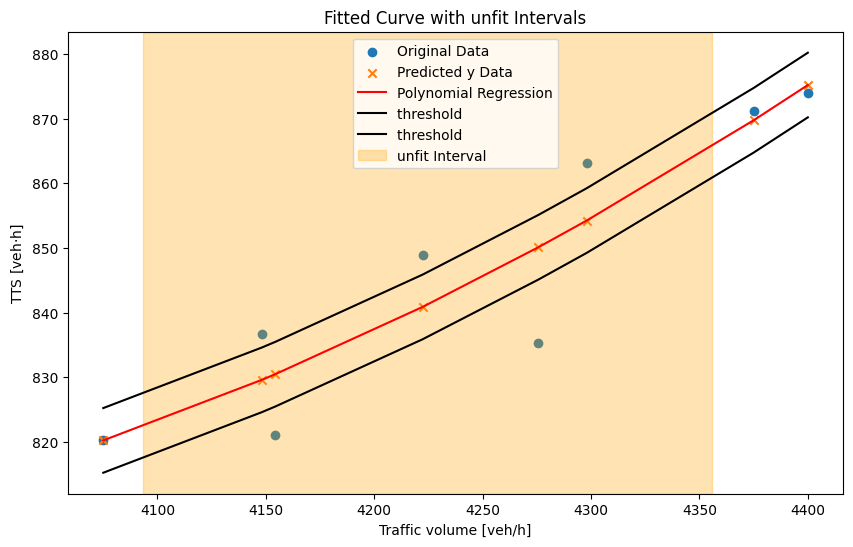

equation,
 y =  0.00016308428530134846x^2  -1.2130237824512191x^1 + 3055.18518393024 
unfit_points
 [(4075.0, 820.2638888888889), (4148.002958579882, 836.6250000000001), (4154.285714285714, 821.0277777777777), (4222.337278106509, 848.9027777777777), (4275.714285714286, 835.2916666666664), (4298.002958579882, 863.1666666666669), (4375.0, 871.1250000000006), (4400.0, 874.0138888888888)] 
local_unfit_interval
, [[4065.3571428571427, 4093.2507396449705], [4355.750739644971, 4400.0]]
DIFFERENCES 
each_interval  [4065.3571428571427, 4400.0] 
new_unfit_interval   [[4093.2507396449705, 4355.750739644971]]
MAIN interval list from VAL: [[3175.0, 3435.858013937282], [3461.215156794425, 3516.289198606272], [3542.3606271777007, 3794.4033101045293], [3814.3292682926826, 3980.0], [4093.2507396449705, 4355.750739644971]]
Modifier...
[MODC]: intervals list:  [[3175.0, 3435.858013937282], [3461.215156794425, 3516.289198606272], [3542.3606271777007, 3794.4033101045293], [3814.3292682926826, 3980.0], [409

Step #5400.00 (10ms ~= 25.00*RT, ~43600.00UPS, TraCI: 0ms, vehicles TOT 7259 ACT 436 BUF 0
x list [3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0, 3750.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (11ms ~= 22.73*RT, ~30545.45UPS, TraCI: 2ms, vehicles TOT 1362 ACT 336 BUF 0ep #2250.00 (6ms ~= 41.67*RT, ~77000.00UPS, Tra

Step #4475.00 (15ms ~= 16.67*RT, ~43733.33UPS, TraCI: 1ms, vehicles TOT 6206 ACT 656 BUF 0

Step #5400.00 (12ms ~= 20.83*RT, ~36083.33UPS, TraCI: 1ms, vehicles TOT 7349 ACT 433 BUF 0
x list [3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (7ms ~= 35.71*RT, ~50142.86UPS, TraCI: 0ms, vehicles TOT 1381 ACT 351 BUF 0)ep #2250.00 (7ms ~= 35.71*RT, ~73428.57UPS, Tra

Step #5400.00 (16ms ~= 15.62*RT, ~27500.00UPS, TraCI: 1ms, vehicles TOT 7439 ACT 440 BUF 0
x list [3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3899.6794871794873, 3

Step #4025.00 (10ms ~= 25.00*RT, ~73600.00UPS, TraCI: 0ms, vehicles TOT 5739 ACT 736 BUF 0

Step #5400.00 (6ms ~= 41.67*RT, ~71500.00UPS, TraCI: 0ms, vehicles TOT 7529 ACT 429 BUF 0)
x list [3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0, 3950.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~71800.00UPS, TraCI: 1ms, vehicles TOT 1419 ACT 359 BUF 0)ep #2250.00 (6ms ~= 41.67*RT, ~90666.67UPS, Tra

Step #4925.00 (7ms ~= 35.71*RT, ~78714.29UPS, TraCI: 0ms, vehicles TOT 6998 ACT 551 BUF 0)

Step #5400.00 (6ms ~= 41.67*RT, ~76500.00UPS, TraCI: 0ms, vehicles TOT 7619 ACT 459 BUF 0)
x list [4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0, 4100.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~80600.00UPS, TraCI: 1ms, vehicles TOT 1457 ACT 403 BUF 0)ep #2250.00 (7ms ~= 35.71*RT, ~85285.71UPS, Tra

Step #3250.00 (8ms ~= 31.25*RT, ~96375.00UPS, TraCI: 0ms, vehicles TOT 4721 ACT 771 BUF 0)

Step #5400.00 (8ms ~= 31.25*RT, ~57500.00UPS, TraCI: 0ms, vehicles TOT 7799 ACT 460 BUF 0)
x list [4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816568047338, 4148.816

Step #5400.00 (8ms ~= 31.25*RT, ~58250.00UPS, TraCI: 1ms, vehicles TOT 7889 ACT 466 BUF 0)
x list [4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224852071006, 4198.224

Step #5400.00 (8ms ~= 31.25*RT, ~59250.00UPS, TraCI: 0ms, vehicles TOT 7979 ACT 474 BUF 0)
x list [4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224852071006, 4248.224

Step #5400.00 (9ms ~= 27.78*RT, ~52111.11UPS, TraCI: 0ms, vehicles TOT 8069 ACT 469 BUF 0)
x list [4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816568047338, 4298.816

Step #5400.00 (7ms ~= 35.71*RT, ~68285.71UPS, TraCI: 0ms, vehicles TOT 8159 ACT 478 BUF 0)
x list [4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0, 4350.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~90200.00UPS, TraCI: 1ms, vehicles TOT 1550 ACT 451 BUF 0)

Step #5400.00 (5ms ~= 50.00*RT, ~95800.00UPS, TraCI: 1ms, vehicles TOT 8249 ACT 479 BUF 0)
MODX [3200.0, 3248.8636363636365, 3298.4848484848485, 3348.8636363636365, 3400.0, 3500, 3550.0, 3598.972602739726, 3648.6301369863013, 3698.972602739726, 3750.0, 3850.0, 3899.6794871794873, 3950.0, 4100.0, 4148.816568047338, 4198.224852071006, 4248.224852071006, 4298.816568047338, 4350.0] and sim_y_list [441.27777777777777, 463.7222222222224, 469.88888888888886, 506.12499999999994, 522.5972222222222, 577.8333333333333, 574.8055555555557, 632.6111111111111, 674.4027777777779, 690.0416666666667, 717.1249999999998, 776.7499999999999, 767.2222222222221, 791.4583333333337, 842.6527777777777, 819.1805555555558, 843.9583333333333, 857.1944444444445, 863.1666666666669, 869.0416666666666]
MAIN modx [3200.0, 3248.8636363636365, 3298.4848484848485, 3348.8636363636365, 3400.0, 3500, 3550.0, 3598.972602739726, 3648.6301369863013, 3698.972602739726, 3750.0, 3850.0, 3899.6794871794873, 3950.0, 4100.0, 4148.8165

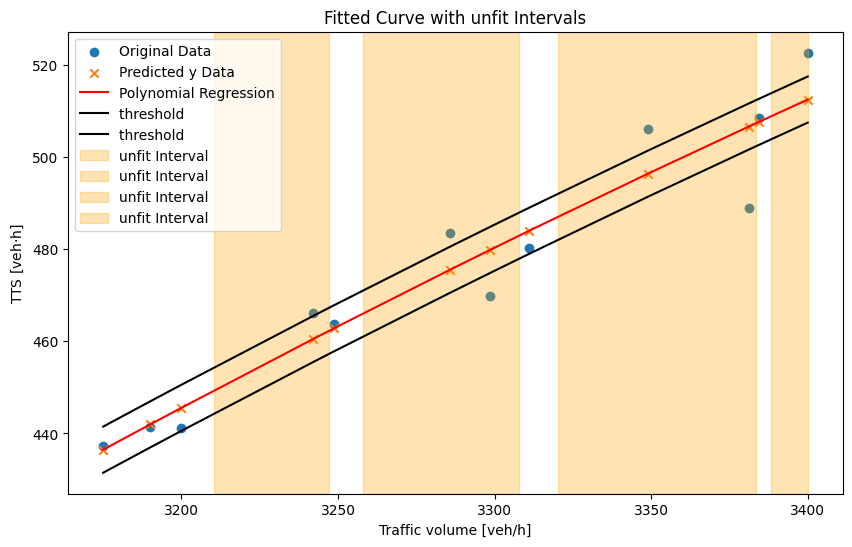

equation,
 y =  -0.00012949436257902666x^2 + 1.1889488956168062x^1  -2033.0379146474959 
unfit_points
 [(3175.0, 437.3611111111109), (3190.0, 441.37499999999994), (3200.0, 441.27777777777777), (3242.1602787456445, 466.222222222222), (3248.8636363636365, 463.7222222222224), (3285.714285714286, 483.44444444444446), (3298.4848484848485, 469.88888888888886), (3310.8885017421603, 480.2916666666666), (3348.8636363636365, 506.12499999999994), (3381.184668989547, 488.86111111111114), (3384.285714285714, 508.3750000000001), (3400.0, 522.5972222222222)] 
local_unfit_interval
, [[3175.0, 3210.5400696864112], [3247.1877969591387, 3258.0762987012986], [3307.7875884278324, 3320.3822853975294], [3383.5104529616724, 3388.214285714286], [3400.0, 3435.858013937282]]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


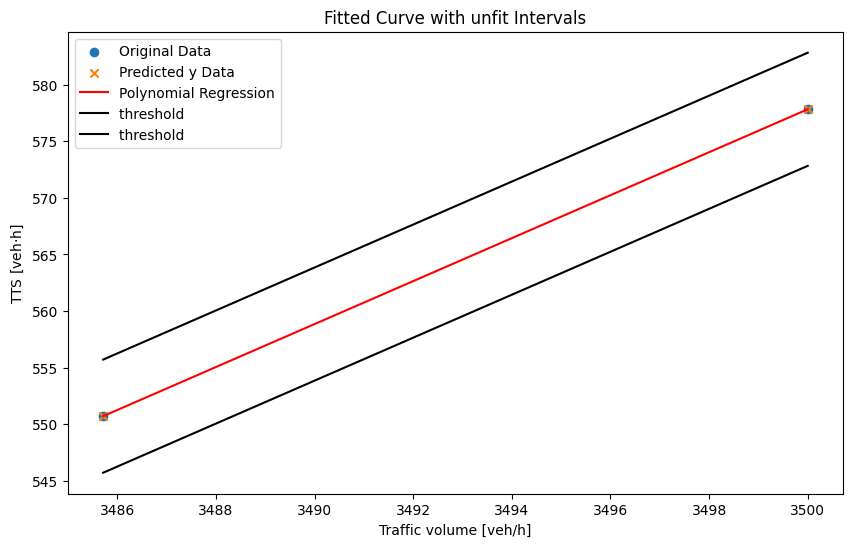

equation,
 y =  0.0002640950563138503x^2 + 0.053857392321904306x^1  -2845.8319796379974 
unfit_points
 [(3485.714285714286, 550.7083333333331), (3500.0, 577.8333333333333)] 
local_unfit_interval
, [[3461.215156794425, 3516.289198606272]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3542.3606271777007, 3550.0]]


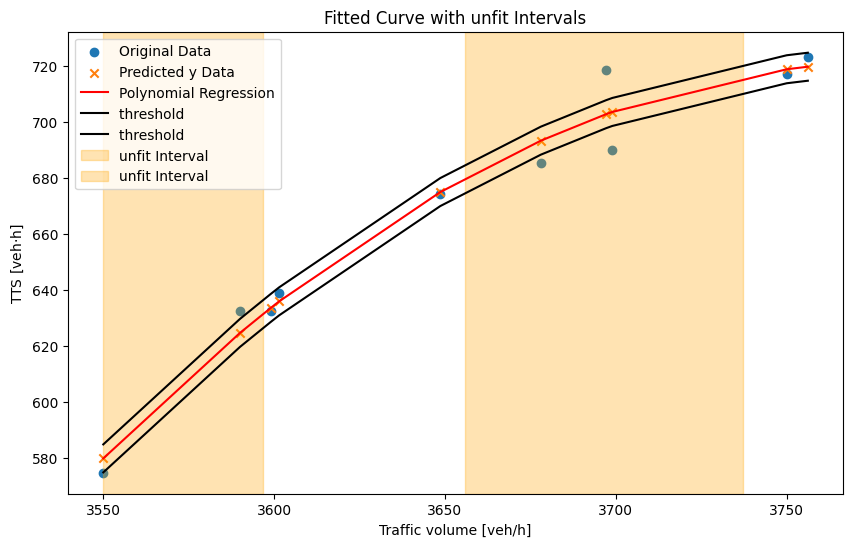

equation,
 y =  -0.0026592147801538482x^2 + 20.107179412981765x^1  -37287.81133818989 
unfit_points
 [(3550.0, 574.8055555555557), (3590.0, 632.6111111111111), (3598.972602739726, 632.6111111111111), (3601.480836236934, 639.0), (3648.6301369863013, 674.4027777777779), (3678.048780487805, 685.3333333333334), (3697.142857142857, 718.6944444444443), (3698.972602739726, 690.0416666666667), (3750.0, 717.1249999999998), (3756.184668989547, 723.3611111111113)] 
local_unfit_interval
, [[3542.3606271777007, 3550.0], [3596.7294520547944, 3655.984797861677], [3737.2431506849316, 3794.4033101045293]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3814.3292682926826, 3835.8885017421603]]


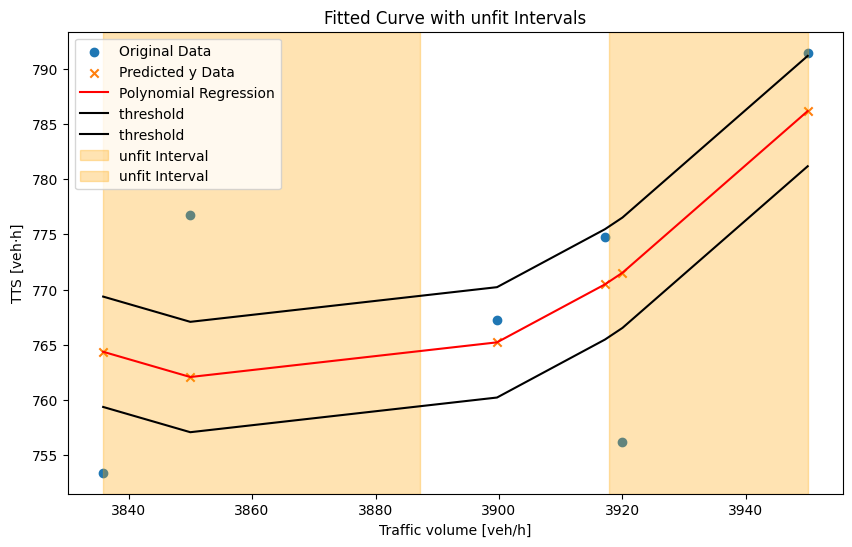

equation,
 y =  0.0035323938364492467x^2  -27.311679545998686x^1 + 53553.132825271256 
unfit_points
 [(3835.8885017421603, 753.4027777777779), (3850.0, 776.7499999999999), (3899.6794871794873, 767.2222222222221), (3917.1602787456445, 774.7777777777777), (3920.0, 756.2083333333334), (3950.0, 791.4583333333337)] 
local_unfit_interval
, [[3814.3292682926826, 3835.8885017421603], [3887.2596153846152, 3917.8702090592333], [3950.0, 3980.0]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[4093.2507396449705, 4100.0]]


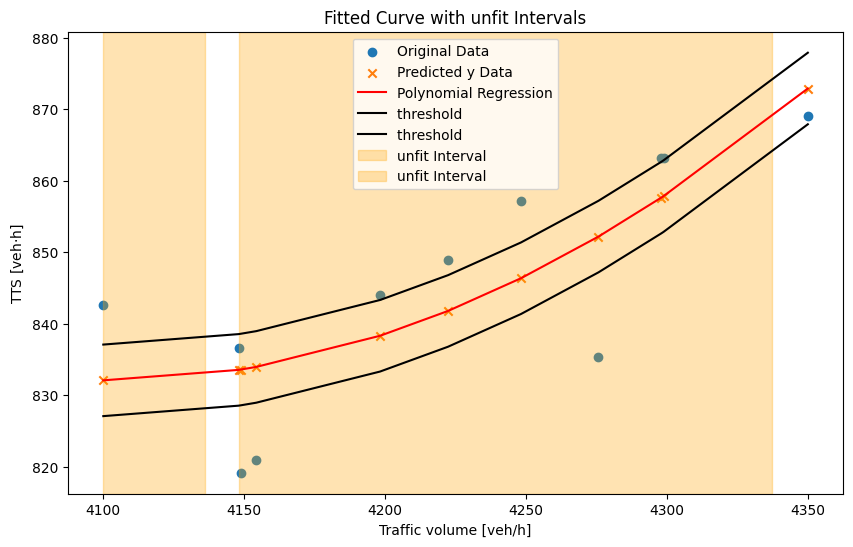

equation,
 y =  0.0006568790499691329x^2  -5.387485815389662x^1 + 11878.64453436698 
unfit_points
 [(4100.0, 842.6527777777777), (4148.002958579882, 836.6250000000001), (4148.816568047338, 819.1805555555558), (4154.285714285714, 821.0277777777777), (4198.224852071006, 843.9583333333333), (4222.337278106509, 848.9027777777777), (4248.224852071006, 857.1944444444445), (4275.714285714286, 835.2916666666664), (4298.002958579882, 863.1666666666669), (4298.816568047338, 863.1666666666669), (4350.0, 869.0416666666666)] 
local_unfit_interval
, [[4093.2507396449705, 4100.0], [4136.002218934911, 4148.206360946746], [4337.204142011835, 4355.750739644971]]
DIFFERENCES 
each_interval  [4093.2507396449705, 4355.750739644971] 
new_unfit_interval   [[4100.0, 4136.002218934911], [4148.206360946746, 4337.204142011835]]
MAIN interval list from VAL: [[3210.5400696864112, 3247.1877969591387], [3258.0762987012986, 3307.7875884278324], [3320.3822853975294, 3383.5104529616724], [3388.214285714286, 3400.0], [3

Step #4575.00 (6ms ~= 41.67*RT, ~102500.00UPS, TraCI: 1ms, vehicles TOT 6261 ACT 615 BUF 0

Step #5400.00 (5ms ~= 50.00*RT, ~84000.00UPS, TraCI: 0ms, vehicles TOT 7258 ACT 420 BUF 0)
x list [3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0, 3725.0]
Running sumo simulator
 Retrying in 1 seconds
Step #3350.00 (6ms ~= 41.67*RT, ~100333.33UPS, TraCI: 0ms, vehicles TOT 4583 ACT 602 BUF 0tep #1125.00 (5ms ~= 50.00*RT, ~71400.00UPS, 

Step #5400.00 (8ms ~= 31.25*RT, ~55250.00UPS, TraCI: 0ms, vehicles TOT 7259 ACT 442 BUF 0)
x list [3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0, 3850.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~70200.00UPS, TraCI: 0ms, vehicles TOT 1381 ACT 351 BUF 0)ep #2250.00 (6ms ~= 41.67*RT, ~85666.67UPS, Tra

Step #5400.00 (6ms ~= 41.67*RT, ~73333.33UPS, TraCI: 0ms, vehicles TOT 7439 ACT 440 BUF 0)
x list [3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0, 3875.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (7ms ~= 35.71*RT, ~52000.00UPS, TraCI: 0ms, vehicles TOT 1400 ACT 364 BUF 0)ep #2250.00 (6ms ~= 41.67*RT, ~86166.67UPS, Tra

Step #5400.00 (6ms ~= 41.67*RT, ~75833.33UPS, TraCI: 0ms, vehicles TOT 7529 ACT 455 BUF 0)
x list [3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925, 3925]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~69200.00UPS, TraCI: 1ms, vehicles TOT 1400 ACT 346 BUF 0)ep #2250.00 (6ms ~= 41.67*RT, ~80833.33UPS, TraCI: 1ms, vehicles TOT 3063 ACT 485 BUF 0)p #3375.00 (7ms ~= 35.71*RT, ~101714.29UPS, TraCI: 0ms, vehicles TOT 4790 ACT 712 BUF 0

(6ms ~= 41.67*RT, ~92000.00UPS, TraCI: 0ms, vehicles TOT 6827 ACT 552 BUF 0)

Step #5400.00 (6ms ~= 41.67*RT, ~77833.33UPS, TraCI: 0ms, vehicles TOT 7529 ACT 467 BUF 0)
x list [4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125, 4125]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~78200.00UPS, TraCI: 1ms, vehicles TOT 1475 ACT 391 BUF 0)ep #2250.00 (7ms ~= 35.71*RT, ~85000.00UPS, TraCI: 0ms, vehicles TOT 3213 ACT 595 BUF 0)

Step #5400.00 (6ms ~= 41.67*RT, ~77000.00UPS, TraCI: 0ms, vehicles TOT 7889 ACT 462 BUF 0)
x list [4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0, 4150.0]
Running sumo simulator
 Retrying in 1 seconds
Step #2225.00 (7ms ~= 35.71*RT, ~83571.43UPS, TraCI: 0ms, vehicles TOT 3175 ACT 585 BUF 0)tep #1125.00 (5ms ~= 50.00*RT, ~79200.00UPS, 

Step #5400.00 (6ms ~= 41.67*RT, ~78833.33UPS, TraCI: 0ms, vehicles TOT 7889 ACT 473 BUF 0)
x list [4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557522123894, 4174.557

(5ms ~= 50.00*RT, ~98800.00UPS, TraCI: 0ms, vehicles TOT 7685 ACT 494 BUF 0)

Step #5400.00 (5ms ~= 50.00*RT, ~92600.00UPS, TraCI: 1ms, vehicles TOT 7979 ACT 463 BUF 0)
x list [4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262536873156, 4199.262

Step #5400.00 (5ms ~= 50.00*RT, ~94800.00UPS, TraCI: 1ms, vehicles TOT 7979 ACT 474 BUF 0)
x list [4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115044247787, 4224.115

Step #5300.00 (6ms ~= 41.67*RT, ~81333.33UPS, TraCI: 1ms, vehicles TOT 7818 ACT 488 BUF 0)

Step #5400.00 (5ms ~= 50.00*RT, ~94000.00UPS, TraCI: 0ms, vehicles TOT 7979 ACT 470 BUF 0)
x list [4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115044247787, 4249.115

Step #5400.00 (7ms ~= 35.71*RT, ~67428.57UPS, TraCI: 0ms, vehicles TOT 8069 ACT 472 BUF 0)
x list [4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262536873156, 4274.262

Step #5400.00 (5ms ~= 50.00*RT, ~94000.00UPS, TraCI: 0ms, vehicles TOT 8069 ACT 470 BUF 0)
x list [4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557522123894, 4299.557

Step #5400.00 (5ms ~= 50.00*RT, ~92600.00UPS, TraCI: 0ms, vehicles TOT 8159 ACT 463 BUF 0)
x list [4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0, 4325.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (4ms ~= 62.50*RT, ~105750.00UPS, TraCI: 1ms, vehicles TOT 1531 ACT 423 BUF 0

Step #5400.00 (5ms ~= 50.00*RT, ~95600.00UPS, TraCI: 0ms, vehicles TOT 8159 ACT 478 BUF 0)
MODX [3225, 3275.0, 3300.0, 3325.0, 3349.9067164179105, 3375.0, 3575, 3675.0, 3699.9155405405404, 3725.0, 3850.0, 3875.0, 3925, 4125, 4150.0, 4174.557522123894, 4199.262536873156, 4224.115044247787, 4249.115044247787, 4274.262536873156, 4299.557522123894, 4325.0] and sim_y_list [454.2500000000001, 492.027777777778, 492.68055555555554, 489.6527777777779, 508.52777777777794, 511.38888888888886, 635.1111111111112, 661.4444444444441, 714.3055555555557, 716.6805555555554, 776.7499999999999, 780.1250000000005, 760.680555555556, 830.0138888888887, 831.7083333333336, 842.1805555555559, 843.9583333333333, 863.2222222222222, 860.9861111111112, 867.8055555555552, 870.5277777777778, 862.361111111111]
MAIN modx [3225, 3275.0, 3300.0, 3325.0, 3349.9067164179105, 3375.0, 3575, 3675.0, 3699.9155405405404, 3725.0, 3850.0, 3875.0, 3925, 4125, 4150.0, 4174.557522123894, 4199.262536873156, 4224.115044247787, 4249.11

/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


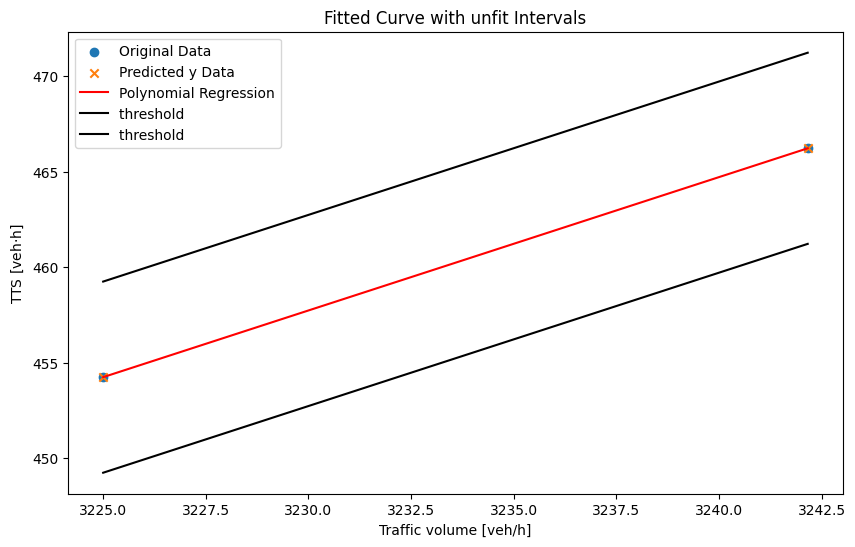

equation,
 y =  0.0001005422865254205x^2 + 0.047447533025763405x^1  -744.470912801539 
unfit_points
 [(3225.0, 454.2500000000001), (3242.1602787456445, 466.222222222222)] 
local_unfit_interval
, [[3210.5400696864112, 3247.1877969591387]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3258.0762987012986, 3288.9069264069267]]


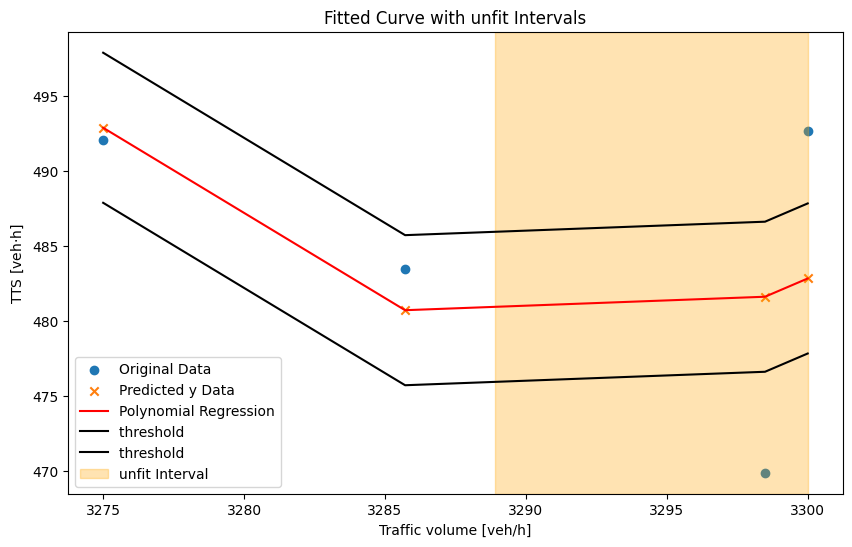

equation,
 y =  0.051305669010310855x^2  -337.73645875852964x^1 + 556294.4111542909 
unfit_points
 [(3275.0, 492.027777777778), (3285.714285714286, 483.44444444444446), (3298.4848484848485, 469.88888888888886), (3300.0, 492.68055555555554)] 
local_unfit_interval
, [[3258.0762987012986, 3288.9069264069267], [3300.0, 3307.7875884278324]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3320.3822853975294, 3356.180037313433]]


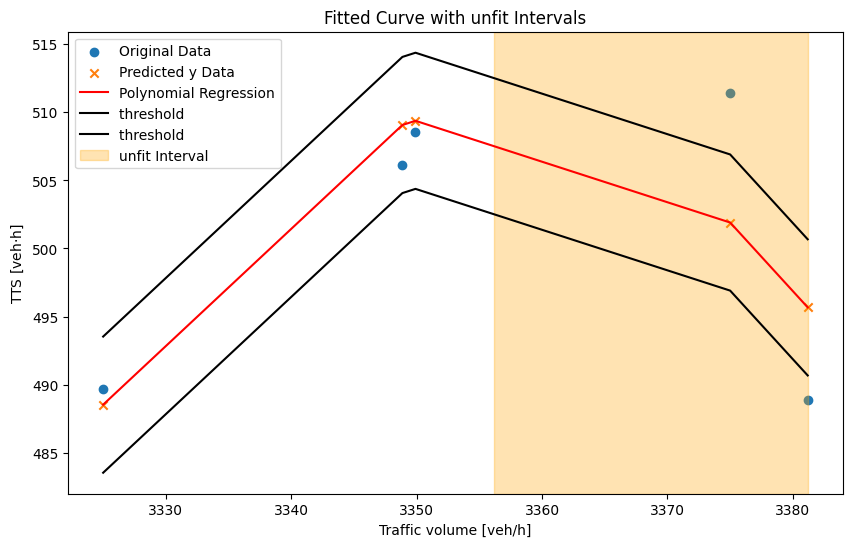

equation,
 y =  -0.02269545408217177x^2 + 152.32704882295772x^1  -255086.47768533023 
unfit_points
 [(3325.0, 489.6527777777779), (3348.8636363636365, 506.12499999999994), (3349.9067164179105, 508.52777777777794), (3375.0, 511.38888888888886), (3381.184668989547, 488.86111111111114)] 
local_unfit_interval
, [[3320.3822853975294, 3356.180037313433], [3381.184668989547, 3383.5104529616724]]
This is UNFIT POINTS  [(3400.0, 522.5972222222222)]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


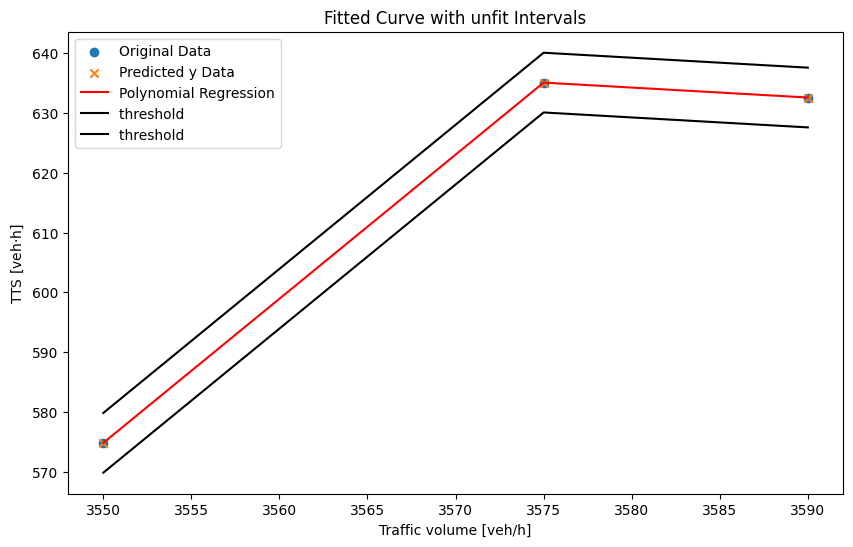

equation,
 y =  -4.75171546666619e-17x^6 + 4.0273220386229863e-16x^5 + 3.66107223541783e-10x^4 + 1.7411442535634102e-06x^3 + 0.004660620584871794x^2  -0.020286601898792632x^1  -99250.036356854 
unfit_points
 [(3550.0, 574.8055555555557), (3575.0, 635.1111111111112), (3590.0, 632.6111111111111)] 
local_unfit_interval
, [[3550.0, 3596.7294520547944]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[3655.984797861677, 3675.0]]


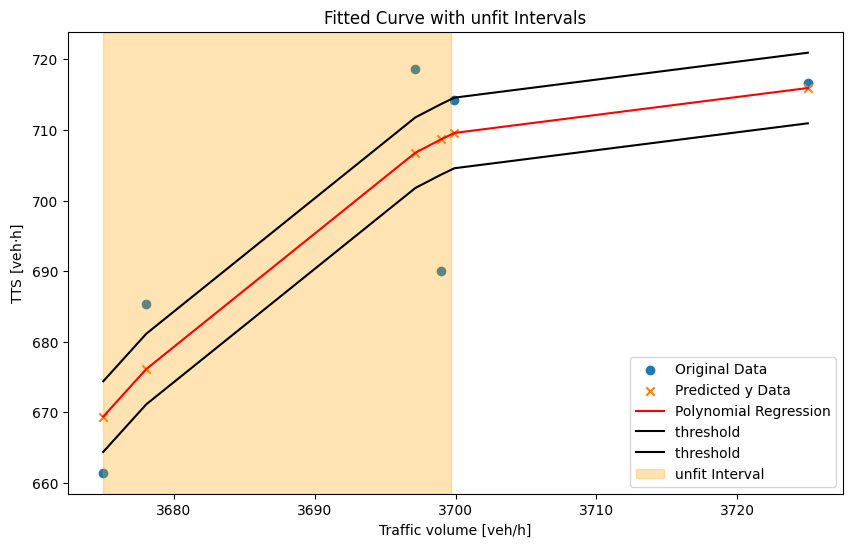

equation,
 y =  -0.027174815405671564x^2 + 202.02447594331764x^1  -374757.6812185445 
unfit_points
 [(3675.0, 661.4444444444441), (3678.048780487805, 685.3333333333334), (3697.142857142857, 718.6944444444443), (3698.972602739726, 690.0416666666667), (3699.9155405405404, 714.3055555555557), (3725.0, 716.6805555555554)] 
local_unfit_interval
, [[3655.984797861677, 3675.0], [3699.6798060903366, 3737.2431506849316]]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


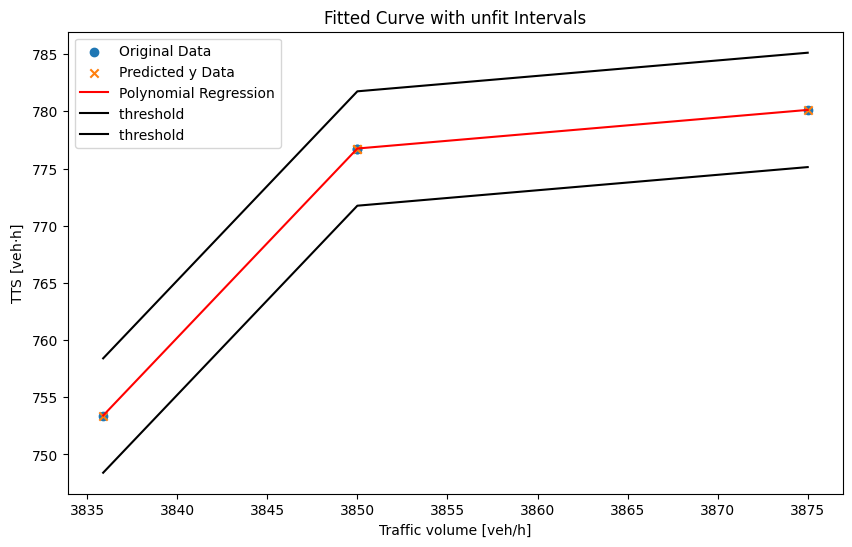

equation,
 y =  -2.1136266076228146e-17x^6 + 2.2987270561658673e-16x^5 + 1.8958638974948883e-10x^4 + 9.7219604829929e-07x^3 + 0.002807755003610379x^2 + 0.005014095575777432x^1  -69355.89835679402 
unfit_points
 [(3835.8885017421603, 753.4027777777779), (3850.0, 776.7499999999999), (3850.0, 776.7499999999999), (3875.0, 780.1250000000005)] 
local_unfit_interval
, [[3835.8885017421603, 3887.2596153846152]]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


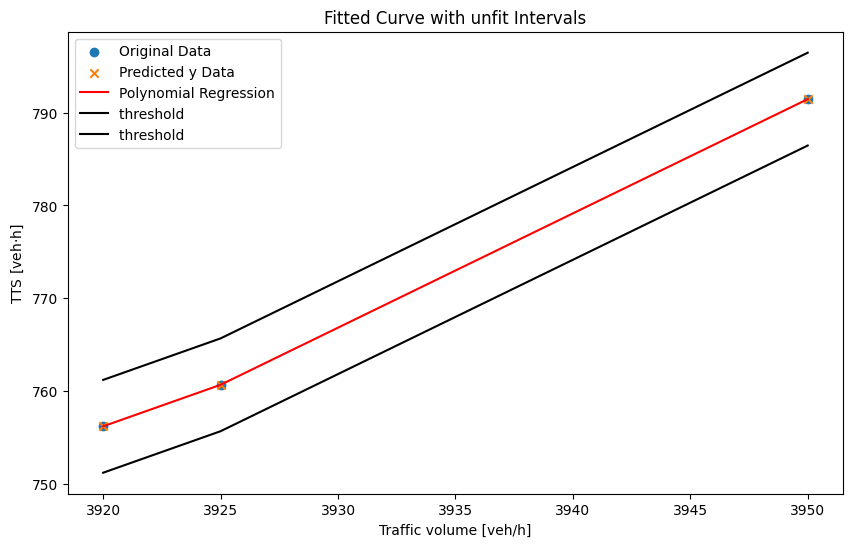

equation,
 y =  5.391917757335203e-18x^6 + 2.743832702097043e-16x^5  -4.84271129012987e-11x^4  -2.5612523965837107e-07x^3  -0.0007583014136586311x^2  -0.009283989456220228x^1 + 19489.846966597688 
unfit_points
 [(3920.0, 756.2083333333334), (3925.0, 760.680555555556), (3950.0, 791.4583333333337)] 
local_unfit_interval
, [[3917.8702090592333, 3950.0]]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:41: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


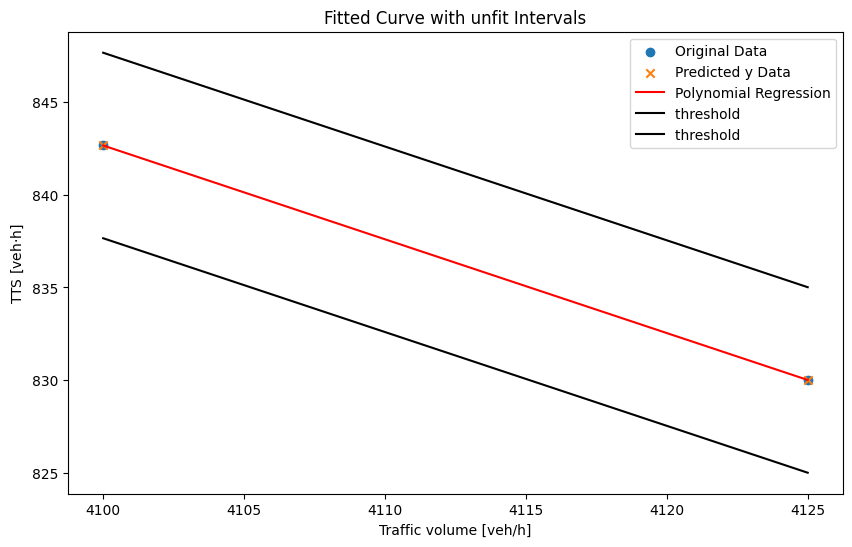

equation,
 y =  -6.970666664614938e-05x^2 + 0.06778177760900354x^1 + 1736.5165559026343 
unfit_points
 [(4100.0, 842.6527777777777), (4125.0, 830.0138888888887)] 
local_unfit_interval
, [[4100.0, 4136.002218934911]]
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[4148.206360946746, 4148.816568047338]]


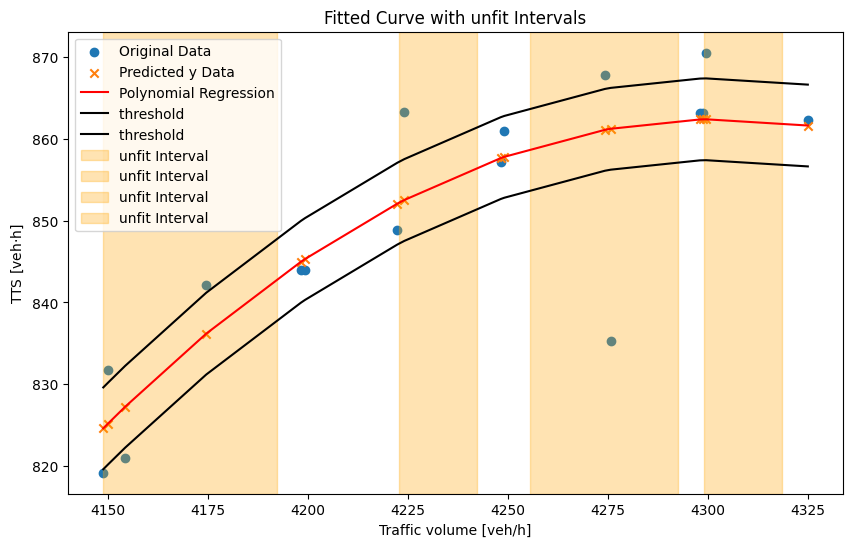

equation,
 y =  -0.0015920977596286282x^2 + 13.701258836779969x^1  -28615.13271629498 
unfit_points
 [(4148.816568047338, 819.1805555555558), (4150.0, 831.7083333333336), (4154.285714285714, 821.0277777777777), (4174.557522123894, 842.1805555555559), (4198.224852071006, 843.9583333333333), (4199.262536873156, 843.9583333333333), (4222.337278106509, 848.9027777777777), (4224.115044247787, 863.2222222222222), (4248.224852071006, 857.1944444444445), (4249.115044247787, 860.9861111111112), (4274.262536873156, 867.8055555555552), (4275.714285714286, 835.2916666666664), (4298.002958579882, 863.1666666666669), (4298.816568047338, 863.1666666666669), (4299.557522123894, 870.5277777777778), (4325.0, 862.361111111111)] 
local_unfit_interval
, [[4148.206360946746, 4148.816568047338], [4192.3080195842285, 4222.781719641829], [4242.197400115201, 4255.40191740413], [4292.4307903634835, 4299.001806566477], [4318.6393805309735, 4337.204142011835]]
DIFFERENCES 
each_interval  [4148.206360946746, 4337.2

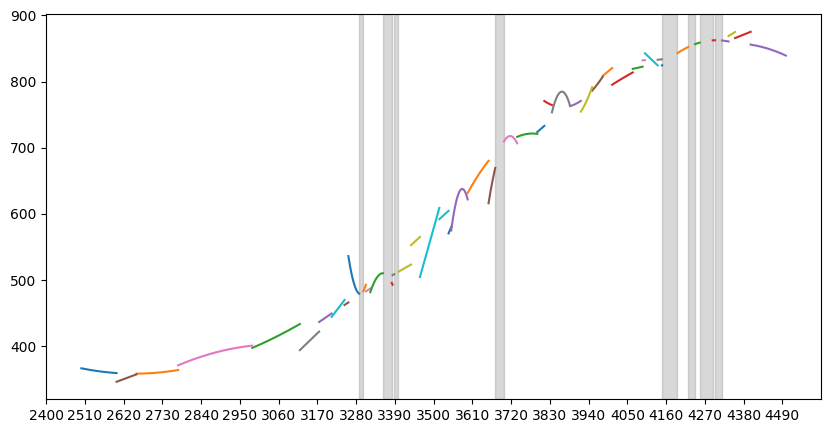

In [1]:
# IMPORT LIBRARIES
import numpy as np

from components_configuration import components
from global_settings import simexSettings,mds

from validator_controller import ValidatorController
from modifier_controller import ModifierController
from simulator_controller import SimulatorController
from logger_utils import Logger

import pickle
import datetime
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

validator_controller_vsl = ValidatorController()
logger = Logger()
logger_main_arguments = {}
is_main_func = True
# Initialize interval list for the first iteration
intervals_list=[[mds['domain_min_interval'], mds['domain_max_interval']]]
#intervals_list=[[2900, 3200]]
# Timestamp for the validator pickle file
count = 0
filename1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

while is_main_func:
    
    # Calls Modifier Controller
    mod_outcome = ModifierController.control(intervals_list=intervals_list,selected_modifier=components['modifierA'], do_plot=simexSettings['do_plot'])
    mod_x_list = mod_outcome[0]
    checked_intervals = mod_outcome[1]
    print("MAIN mod outcome", mod_outcome)  

    
    # breaks loop if iterations end by granularity reached
    if not mod_x_list: # FALSE IF ['modifier_data_point'] < mdv['modifier_incremental_unit']:
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no generated points'
        logger_main_arguments['remaining_unfit_intervals'] = checked_intervals
        logger.log_main(logger_main_arguments)
        break
    
    # Calls Simulator
    mod_x,sim_y_list = SimulatorController.simulate(mod_x_list,selected_simulator=components['sumo_simulator_vsl'])
    print(f"MODX {mod_x} and sim_y_list {sim_y_list}")
    assert len(mod_x) == len(sim_y_list)

    print("MAIN modx", mod_x)  

    # Calls Validator controller
    intervals_list =  validator_controller_vsl.validate(mod_x_list=np.array(mod_x),sim_y_list=np.array(sim_y_list), selected_validator=components['validator'],global_interval=[mds["domain_min_interval"], mds["domain_max_interval"]])
    print("MAIN interval list from VAL:", intervals_list)
    # Loop number ( Loop-1,Loop-2..etc)
    count +=1
    save_object(validator_controller_vsl,f"vc_vsl_loop-{count}-{filename1}.pkl")
    
    # Updates interval_list to new range output from validator controller
    # No more unfit intervals -> write MAIN log
    if not intervals_list:
        is_main_func = False
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no unfit intervals'
        logger.log_main(logger_main_arguments)

# MAIN cycle completed/interrupted -> write OVERALL statistics        
logger_main_arguments['log_contex'] = 'Overall Stats'                          
logger_main_arguments['main_status'] = 'end cycle'
logger.log_main(logger_main_arguments)
